In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import sys
import torch
from torch.utils.data import DataLoader, Dataset
from properscoring import crps_ensemble
import random


sys.path.append(os.path.abspath('../src'))
project_dir = Path.cwd().parent

from data_tools.data_utils import SeroDataset, PartialCountDataset, TrueCountDataset
from model_tools.train_utils import BaseTrain, SparsePropTrain, SeroTrain
from model_tools.models import NowcastPNN, PropPNN, SparsePropPNN, SeroPNN
from model_tools.evaluation import eval_pnn, eval_prop_pnn, eval_sparse_prop_pnn, eval_sero_pnn, plot_pnn_preds, plot_prop_pnn_preds, plot_sero_pnn_preds
D = 40
M = 50
T = 15
period = "Q"

start_year = 2019
end_year = 2023
data_split = [0.7, 0.15, 0.15]
seed = 123

# 123, 2019, 2023, 15

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False




In [2]:
# Create serotype obj
denv_df = pd.read_csv(project_dir / "data" / "transformed" / "denv_df.csv")
sero_props = pd.read_csv(project_dir / "data" / "transformed" / "sero_props.csv")

denv_df['Collection date'] = pd.to_datetime(denv_df['Collection date']).dt.to_period(period)
denv_df['Submission date'] = pd.to_datetime(denv_df['Submission date']).dt.to_period(period)
sero_props['Collection date'] = pd.to_datetime(sero_props['Collection date']).dt.to_period(period)
sero_dataset = SeroDataset(denv_df, sero_props, T=T, period=period)

/var/folders/5f/9g0vtmkj22j_xbhxyrknnv140000gn/T/ipykernel_5207/297251051.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  denv_df['Collection date'] = pd.to_datetime(denv_df['Collection date']).dt.to_period(period)
/var/folders/5f/9g0vtmkj22j_xbhxyrknnv140000gn/T/ipykernel_5207/297251051.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  denv_df['Submission date'] = pd.to_datetime(denv_df['Submission date']).dt.to_period(period)
/var/folders/5f/9g0vtmkj22j_xbhxyrknnv140000gn/T/ipykernel_5207/297251051.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sero_props['Coll

In [3]:
sero_props

,Collection date,DenV1,DenV2,DenV3,DenV4
0,2000Q1,0.676471,0.323529,0.000000,0.000000
1,2000Q2,0.000000,1.000000,0.000000,0.000000
2,2000Q3,0.000000,1.000000,0.000000,0.000000
3,2000Q4,0.000000,1.000000,0.000000,0.000000
4,2001Q1,0.339623,0.396226,0.264151,0.000000
...,...,...,...,...,...
91,2022Q4,0.622642,0.377358,0.000000,0.000000
92,2023Q1,0.838288,0.156956,0.004756,0.000000
93,2023Q2,0.828947,0.171053,0.000000,0.000000
94,2023Q3,0.702128,0.297872,0.000000,0.000000


In [4]:
# Create count obj
delays_df = pd.read_csv(project_dir / "data" / "transformed" / "DENG_delays.csv")
delays_df['Collection date'] = pd.to_datetime(delays_df['Collection date'])

partial_count_dataset = PartialCountDataset(delays_df, D=D, M=M)
true_count_dataset = TrueCountDataset(delays_df)


In [5]:
# End of 2023 appears to have some incomplete data
if end_year == 2023:
    dates = list(pd.date_range(f"{start_year}-01-01",f"{end_year}-12-25", freq='D'))
else:
    dates = list(pd.date_range(f"{start_year}-01-01",f"{end_year}-12-31", freq='D'))
data_split_sizes = (np.array(data_split) * len(dates)).astype(int)

# Ensure dates line up fully, also removing 2023-12-31 as doesn't appear complete
data_split_sizes[-1] = len(dates) - data_split_sizes[:-1].sum()


train_dates = dates[:data_split_sizes[0]]
val_dates = dates[data_split_sizes[0]:data_split_sizes[0]+data_split_sizes[1]]
test_dates = dates[data_split_sizes[0]+data_split_sizes[1]:]


In [6]:
class PNNDataset(Dataset):
    def __init__(self, partial_count_obj, true_count_obj, dates):
        self.partial_count_obj = partial_count_obj
        self.true_count_obj = true_count_obj
        self.dates = dates
    
    def __len__(self):
        return len(self.dates)
    
    def __getitem__(self, index):
        date = self.dates[index]
        obs = self.partial_count_obj.get_obs(date)
        y = self.true_count_obj.get_y(date)
        dow = date.day_of_week
        return (obs, dow), y

set_seed(seed)
train_pnn_dataset = PNNDataset(partial_count_dataset, true_count_dataset, train_dates)
val_pnn_dataset = PNNDataset(partial_count_dataset, true_count_dataset, val_dates)
test_pnn_dataset = PNNDataset(partial_count_dataset, true_count_dataset, test_dates)

g = torch.Generator()
g.manual_seed(seed)

train_loader = DataLoader(train_pnn_dataset, batch_size=32, shuffle=True, generator=g)
val_loader = DataLoader(val_pnn_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_pnn_dataset, batch_size=32, shuffle=False)


In [7]:
pnn_model = NowcastPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
pnn_train = BaseTrain("PNN")
pnn_train.train_model(pnn_model, train_loader, val_loader)

Epoch 1 - Train loss: 6.99e+04 - Val loss: 1.12e+06 - ES count: 0
Epoch 2 - Train loss: 5.34e+04 - Val loss: 6.48e+05 - ES count: 0
Epoch 3 - Train loss: 4.9e+04 - Val loss: 5.24e+05 - ES count: 0
Epoch 4 - Train loss: 4.48e+04 - Val loss: 5.86e+05 - ES count: 1
Epoch 5 - Train loss: 4.22e+04 - Val loss: 3.94e+05 - ES count: 0
Epoch 6 - Train loss: 3.98e+04 - Val loss: 4.61e+05 - ES count: 1
Epoch 7 - Train loss: 3.65e+04 - Val loss: 3.97e+05 - ES count: 2
Epoch 8 - Train loss: 3.45e+04 - Val loss: 3.62e+05 - ES count: 0
Epoch 9 - Train loss: 3.19e+04 - Val loss: 2.67e+05 - ES count: 0
Epoch 10 - Train loss: 3.01e+04 - Val loss: 3.02e+05 - ES count: 1
Epoch 11 - Train loss: 2.83e+04 - Val loss: 2.48e+05 - ES count: 0
Epoch 12 - Train loss: 2.59e+04 - Val loss: 2.66e+05 - ES count: 1
Epoch 13 - Train loss: 2.25e+04 - Val loss: 1.67e+05 - ES count: 0
Epoch 14 - Train loss: 2.11e+04 - Val loss: 2.11e+05 - ES count: 1
Epoch 15 - Train loss: 2.02e+04 - Val loss: 2.22e+05 - ES count: 2
Epoch

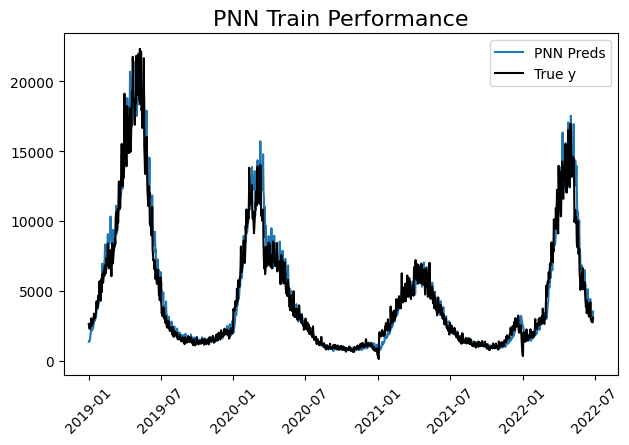

CRPS: 386.10541475667185


In [8]:
pnn_model = NowcastPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
pnn_model.load_state_dict(torch.load(project_dir /"src" / "outputs" / "weights" / f"weights-PNN"))

pnn_train_samples, train_y_true = eval_pnn(train_pnn_dataset, pnn_model)


plot_pnn_preds(pnn_train_samples,train_pnn_dataset, "PNN Train Performance")
print(f"CRPS: {crps_ensemble(train_y_true.squeeze(-1), pnn_train_samples).mean()}")

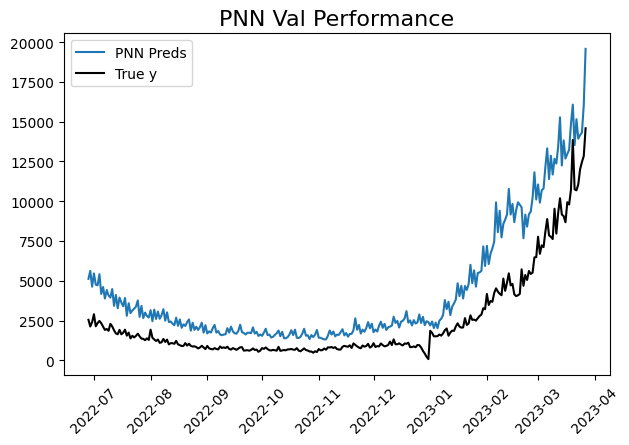

CRPS: 1591.7139882783881


In [9]:
pnn_val_samples, val_y_true = eval_pnn(val_pnn_dataset, pnn_model)
plot_pnn_preds(pnn_val_samples,val_pnn_dataset, "PNN Val Performance")
print(f"CRPS: {crps_ensemble(val_y_true.squeeze(-1), pnn_val_samples).mean()}")

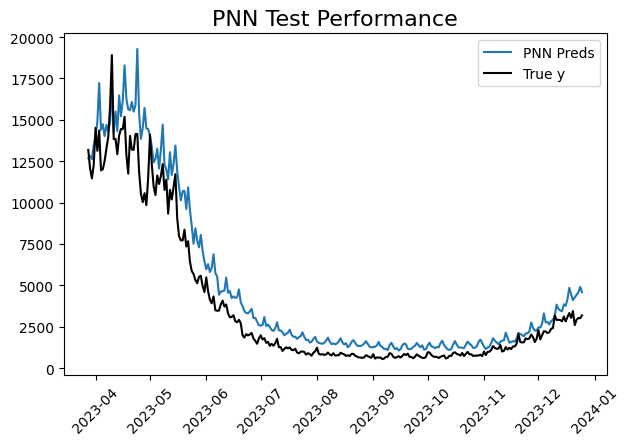

CRPS: 845.2976776556775


In [10]:
pnn_test_samples, test_y_true = eval_pnn(test_pnn_dataset, pnn_model)
plot_pnn_preds(pnn_test_samples,test_pnn_dataset, "PNN Test Performance")
print(f"CRPS: {crps_ensemble(test_y_true.squeeze(-1), pnn_test_samples).mean()}")

In [11]:
class PropPNNDataset(Dataset):
    def __init__(self, partial_count_obj, true_count_obj, dates):
        self.partial_count_obj = partial_count_obj
        self.true_count_obj = true_count_obj
        self.dates = dates
    
    def __len__(self):
        return len(self.dates)
    
    def __getitem__(self, index):
        date = self.dates[index]
        obs = self.partial_count_obj.get_obs(date)
        z = self.true_count_obj.get_z(date)
        dow = date.day_of_week
        return (obs, dow), z

set_seed(seed)
train_prop_pnn_dataset = PropPNNDataset(partial_count_dataset, true_count_dataset, train_dates)
val_prop_pnn_dataset = PropPNNDataset(partial_count_dataset, true_count_dataset, val_dates)
test_prop_pnn_dataset = PropPNNDataset(partial_count_dataset, true_count_dataset, test_dates)

g = torch.Generator()
g.manual_seed(seed)

train_loader = DataLoader(train_prop_pnn_dataset, batch_size=32, shuffle=True, generator=g)
val_loader = DataLoader(val_prop_pnn_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_prop_pnn_dataset, batch_size=32, shuffle=False)


In [12]:
prop_pnn_model = PropPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
prop_pnn_train = BaseTrain("PropPNN")
prop_pnn_train.train_model(prop_pnn_model, train_loader, val_loader)

Epoch 1 - Train loss: 8.27e+03 - Val loss: 7.16e+04 - ES count: 0
Epoch 2 - Train loss: 7.46e+03 - Val loss: 5.58e+04 - ES count: 0
Epoch 3 - Train loss: 4.77e+03 - Val loss: 3.1e+04 - ES count: 0
Epoch 4 - Train loss: 4.17e+03 - Val loss: 3.14e+04 - ES count: 1
Epoch 5 - Train loss: 3.89e+03 - Val loss: 2.76e+04 - ES count: 0
Epoch 6 - Train loss: 3.52e+03 - Val loss: 3.49e+04 - ES count: 1
Epoch 7 - Train loss: 3.48e+03 - Val loss: 2.4e+04 - ES count: 0
Epoch 8 - Train loss: 3.09e+03 - Val loss: 2.03e+04 - ES count: 0
Epoch 9 - Train loss: 3.04e+03 - Val loss: 2.29e+04 - ES count: 1
Epoch 10 - Train loss: 2.71e+03 - Val loss: 1.88e+04 - ES count: 0
Epoch 11 - Train loss: 2.61e+03 - Val loss: 1.86e+04 - ES count: 0
Epoch 12 - Train loss: 2.44e+03 - Val loss: 1.42e+04 - ES count: 0
Epoch 13 - Train loss: 2.21e+03 - Val loss: 1.46e+04 - ES count: 1
Epoch 14 - Train loss: 2.38e+03 - Val loss: 1.19e+04 - ES count: 0
Epoch 15 - Train loss: 2.16e+03 - Val loss: 1.26e+04 - ES count: 1
Epoch 

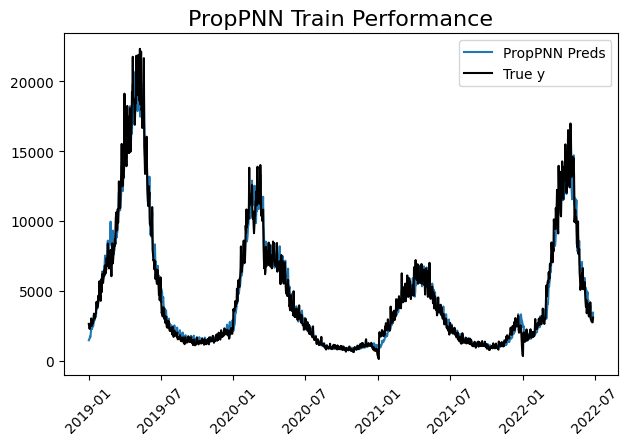

CRPS: 319.63836640502353


In [13]:
prop_pnn_model = PropPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
prop_pnn_model.load_state_dict(torch.load(project_dir /"src" / "outputs" / "weights" / f"weights-PropPNN"))

prop_pnn_train_samples, train_z_true = eval_prop_pnn(train_prop_pnn_dataset, prop_pnn_model)
plot_prop_pnn_preds(prop_pnn_train_samples,train_prop_pnn_dataset, "PropPNN Train Performance")

train_y_true = train_z_true.sum(-1)
print(f"CRPS: {crps_ensemble(train_y_true.squeeze(-1), prop_pnn_train_samples).mean()}")

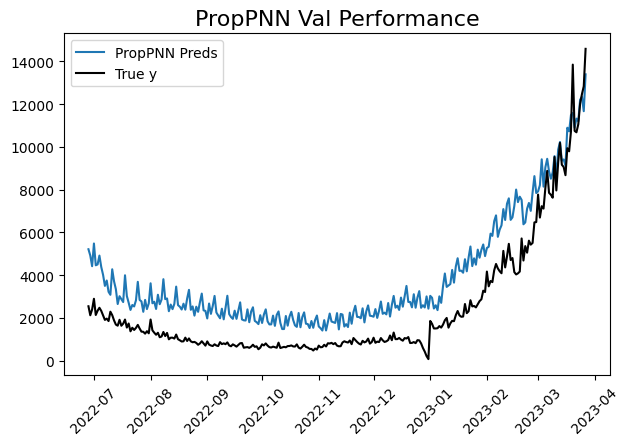

CRPS: 1321.652167032967


In [14]:
prop_pnn_val_samples, val_z_true = eval_prop_pnn(val_prop_pnn_dataset, prop_pnn_model)
plot_prop_pnn_preds(prop_pnn_val_samples,val_prop_pnn_dataset, "PropPNN Val Performance")

val_y_true = val_z_true.sum(-1)
print(f"CRPS: {crps_ensemble(val_y_true.squeeze(-1), prop_pnn_val_samples).mean()}")

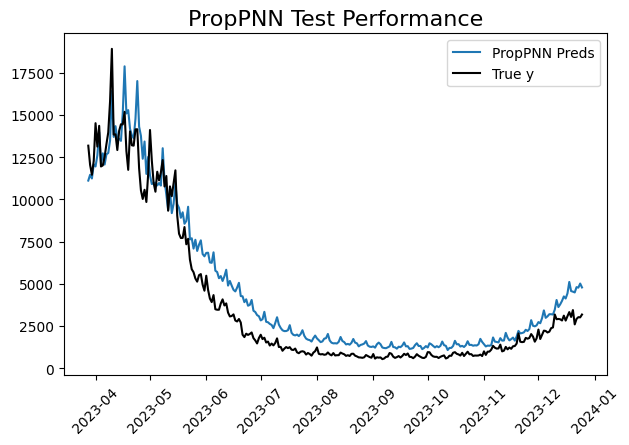

CRPS: 833.8186139194138


In [15]:
prop_pnn_test_samples, test_z_true = eval_prop_pnn(test_prop_pnn_dataset, prop_pnn_model)
plot_prop_pnn_preds(prop_pnn_test_samples,test_prop_pnn_dataset, "PropPNN Test Performance")

test_y_true = test_z_true.sum(-1)
print(f"CRPS: {crps_ensemble(test_y_true.squeeze(-1), prop_pnn_test_samples).mean()}")

In [16]:
set_seed(seed)
train_prop_pnn_dataset = PropPNNDataset(partial_count_dataset, true_count_dataset, train_dates)
val_prop_pnn_dataset = PropPNNDataset(partial_count_dataset, true_count_dataset, val_dates)
test_prop_pnn_dataset = PropPNNDataset(partial_count_dataset, true_count_dataset, test_dates)

g = torch.Generator()
g.manual_seed(seed)

train_loader = DataLoader(train_prop_pnn_dataset, batch_size=32, shuffle=True, generator=g)
val_loader = DataLoader(val_prop_pnn_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_prop_pnn_dataset, batch_size=32, shuffle=False)


In [17]:
sparse_prop_pnn_model = SparsePropPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
sparse_prop_pnn_train = SparsePropTrain("SparsePropPNN")
sparse_prop_pnn_train.train_model(sparse_prop_pnn_model, train_loader, val_loader)

Epoch 1 - Train loss: 2.62e+05 - Val loss: 2.04e+06 - ES count: 0
Epoch 2 - Train loss: 1.71e+05 - Val loss: 1.08e+06 - ES count: 0
Epoch 3 - Train loss: 1.17e+05 - Val loss: 1.02e+06 - ES count: 0
Epoch 4 - Train loss: 1.15e+05 - Val loss: 1.02e+06 - ES count: 0
Epoch 5 - Train loss: 9.93e+04 - Val loss: 9.11e+05 - ES count: 0
Epoch 6 - Train loss: 1.05e+05 - Val loss: 9.53e+05 - ES count: 1
Epoch 7 - Train loss: 9.95e+04 - Val loss: 7.97e+05 - ES count: 0
Epoch 8 - Train loss: 8.38e+04 - Val loss: 6.74e+05 - ES count: 0
Epoch 9 - Train loss: 7.72e+04 - Val loss: 7.16e+05 - ES count: 1
Epoch 10 - Train loss: 7.13e+04 - Val loss: 7.06e+05 - ES count: 2
Epoch 11 - Train loss: 7.98e+04 - Val loss: 6.33e+05 - ES count: 0
Epoch 12 - Train loss: 7.24e+04 - Val loss: 4.19e+05 - ES count: 0
Epoch 13 - Train loss: 6.58e+04 - Val loss: 4.51e+05 - ES count: 1
Epoch 14 - Train loss: 6.59e+04 - Val loss: 5.51e+05 - ES count: 2
Epoch 15 - Train loss: 6.42e+04 - Val loss: 4.65e+05 - ES count: 3
Epoc

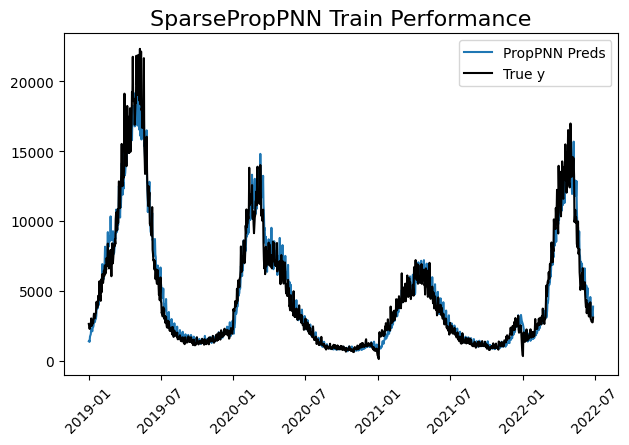

CRPS: 380.4673045525903


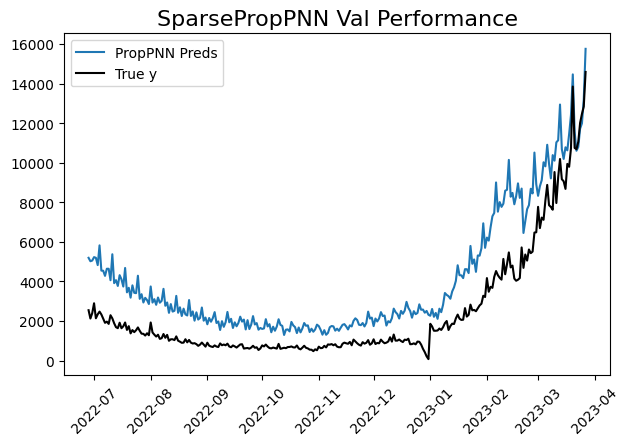

CRPS: 1430.7263047619047


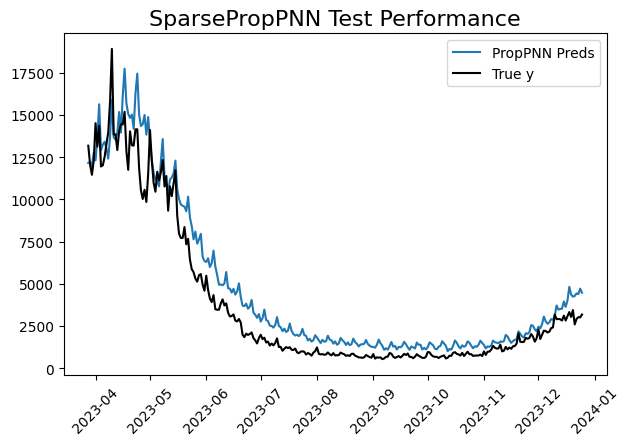

CRPS: 813.02315018315


In [18]:
sparse_prop_pnn_model = SparsePropPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
sparse_prop_pnn_model.load_state_dict(torch.load(project_dir /"src" / "outputs" / "weights" / f"weights-SparsePropPNN"))

sparse_prop_pnn_train_samples, train_z_true = eval_sparse_prop_pnn(train_prop_pnn_dataset, sparse_prop_pnn_model)
plot_prop_pnn_preds(sparse_prop_pnn_train_samples,train_prop_pnn_dataset, "SparsePropPNN Train Performance")

train_y_true = train_z_true.sum(-1)
print(f"CRPS: {crps_ensemble(train_y_true.squeeze(-1), sparse_prop_pnn_train_samples).mean()}")

sparse_prop_pnn_val_samples, val_z_true = eval_sparse_prop_pnn(val_prop_pnn_dataset, sparse_prop_pnn_model)
plot_prop_pnn_preds(sparse_prop_pnn_val_samples,val_prop_pnn_dataset, "SparsePropPNN Val Performance")

val_y_true = val_z_true.sum(-1)
print(f"CRPS: {crps_ensemble(val_y_true.squeeze(-1), sparse_prop_pnn_val_samples).mean()}")

sparse_prop_pnn_test_samples, test_z_true = eval_sparse_prop_pnn(test_prop_pnn_dataset, sparse_prop_pnn_model)
plot_prop_pnn_preds(sparse_prop_pnn_test_samples,test_prop_pnn_dataset, "SparsePropPNN Test Performance")

test_y_true = test_z_true.sum(-1)
print(f"CRPS: {crps_ensemble(test_y_true.squeeze(-1), sparse_prop_pnn_test_samples).mean()}")

In [19]:
class SeroPNNDataset(Dataset):
    def __init__(self, partial_count_obj, true_count_obj, sero_obj, dates):
        self.partial_count_obj = partial_count_obj
        self.true_count_obj = true_count_obj
        self.sero_obj = sero_obj
        self.dates = dates
    
    def __len__(self):
        return len(self.dates)
    
    def __getitem__(self, index):
        date = self.dates[index]
        obs = self.partial_count_obj.get_obs(date)
        sero_obs = self.sero_obj.get_obs(date)
        prop_vec = self.sero_obj.get_prop_vec(date)
        y = self.true_count_obj.get_y_prop(date, prop_vec)
        dow = date.day_of_week
        return (obs, dow, sero_obs), y

set_seed(seed)
sero_props = pd.read_csv(project_dir / "data" / "transformed" / "sero_props.csv")


train_sero_pnn_dataset = SeroPNNDataset(partial_count_dataset, true_count_dataset, sero_dataset, train_dates)
val_sero_pnn_dataset = SeroPNNDataset(partial_count_dataset, true_count_dataset, sero_dataset, val_dates)
test_sero_pnn_dataset = SeroPNNDataset(partial_count_dataset, true_count_dataset,  sero_dataset, test_dates)

g = torch.Generator()
g.manual_seed(seed)

train_loader = DataLoader(train_sero_pnn_dataset, batch_size=32, shuffle=True, generator=g)
val_loader = DataLoader(val_sero_pnn_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_sero_pnn_dataset, batch_size=32, shuffle=False)


In [20]:
N = len(sero_dataset.get_prop_vec("2020-01-01"))
sero_pnn_model = SeroPNN(M=M, D=D, T=T, N=N, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
sero_pnn_train = SeroTrain("SeroPNN", lr=0.0003)
sero_pnn_train.train_model(sero_pnn_model, train_loader, val_loader)



Epoch 1 - Train loss: 1.45e+05 - Val loss: 9.92e+05 - ES count: 0
Epoch 2 - Train loss: 9.42e+04 - Val loss: 6.93e+05 - ES count: 0
Epoch 3 - Train loss: 7.92e+04 - Val loss: 6.44e+05 - ES count: 0
Epoch 4 - Train loss: 6.75e+04 - Val loss: 5.63e+05 - ES count: 0
Epoch 5 - Train loss: 5.76e+04 - Val loss: 4.66e+05 - ES count: 0
Epoch 6 - Train loss: 5.33e+04 - Val loss: 4.88e+05 - ES count: 1
Epoch 7 - Train loss: 5.12e+04 - Val loss: 5.64e+05 - ES count: 2
Epoch 8 - Train loss: 4.65e+04 - Val loss: 4.87e+05 - ES count: 3
Epoch 9 - Train loss: 4.33e+04 - Val loss: 4.84e+05 - ES count: 4
Epoch 10 - Train loss: 4.23e+04 - Val loss: 3.33e+05 - ES count: 0
Epoch 11 - Train loss: 4.15e+04 - Val loss: 4e+05 - ES count: 1
Epoch 12 - Train loss: 3.77e+04 - Val loss: 4.19e+05 - ES count: 2
Epoch 13 - Train loss: 3.34e+04 - Val loss: 3.38e+05 - ES count: 3
Epoch 14 - Train loss: 3.12e+04 - Val loss: 3.37e+05 - ES count: 4
Epoch 15 - Train loss: 2.94e+04 - Val loss: 3.21e+05 - ES count: 0
Epoch 1

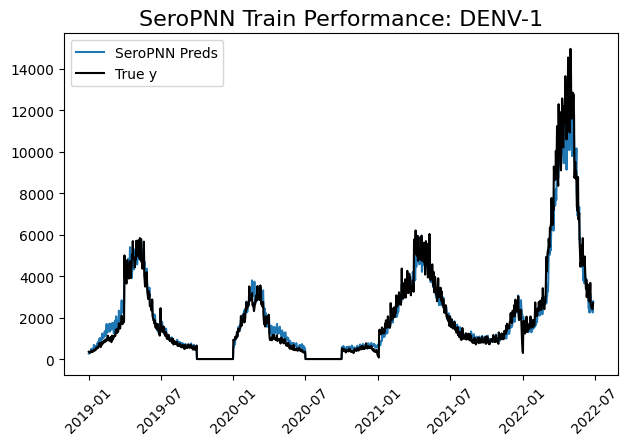

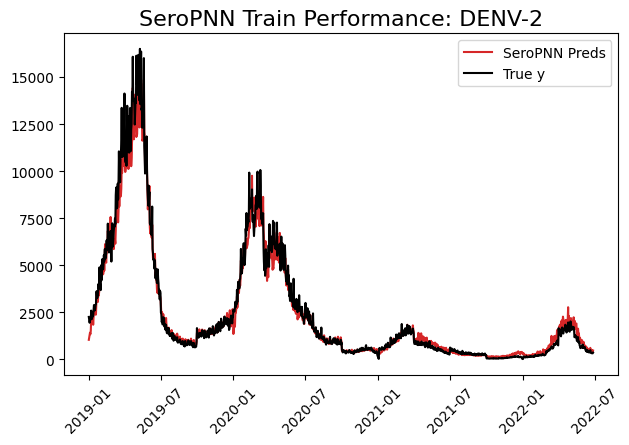

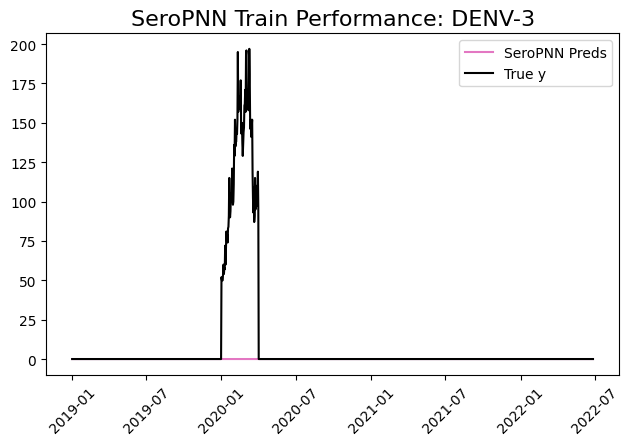

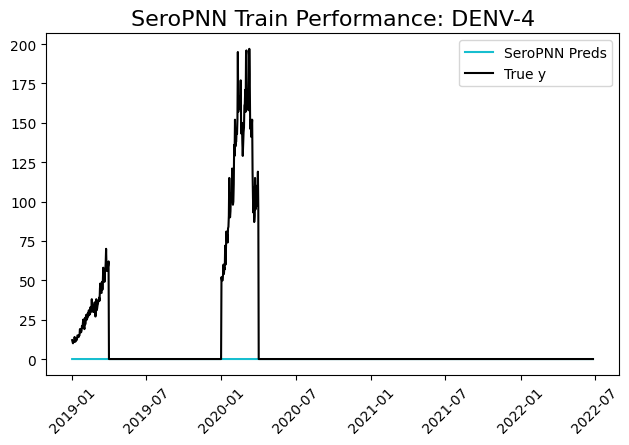

CRPS: 415.34136577708


In [21]:
N = len(sero_dataset.get_prop_vec("2020-01-01"))
sero_pnn_model = SeroPNN(M=M, D=D, T=T, N=N, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
sero_pnn_model.load_state_dict(torch.load(project_dir /"src" / "outputs" / "weights" / f"weights-SeroPNN"))

sero_pnn_train_samples, train_y_true = eval_sero_pnn(train_sero_pnn_dataset, sero_pnn_model, N=N)
plot_sero_pnn_preds(sero_pnn_train_samples, train_sero_pnn_dataset, N, "SeroPNN Train Performance")

crps = 0
crps = sum([crps_ensemble(train_y_true[:,s], sero_pnn_train_samples[:,s,:]).mean() for s in range(N)])
print(f"CRPS: {crps}")


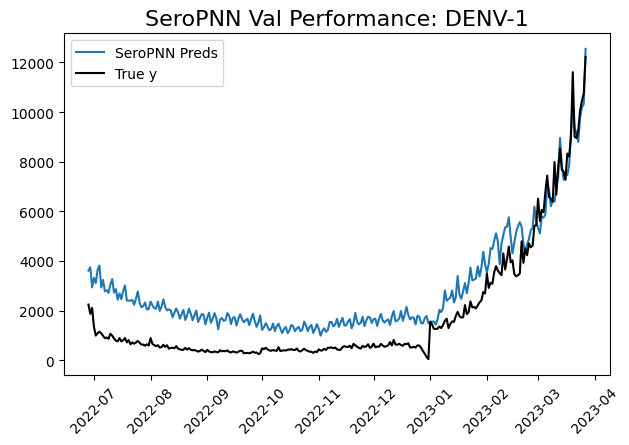

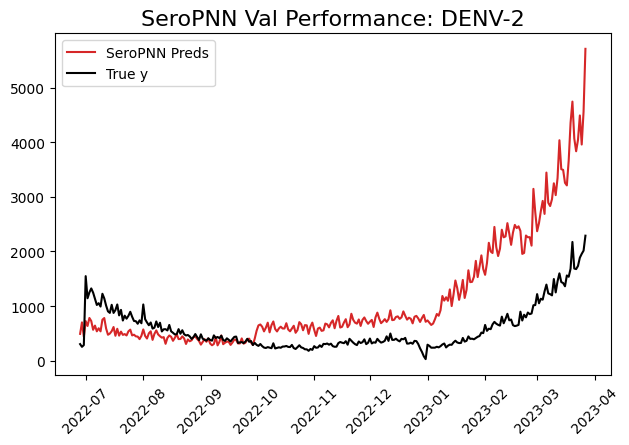

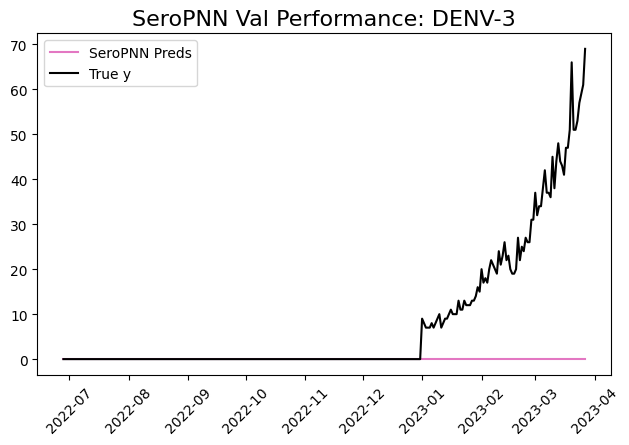

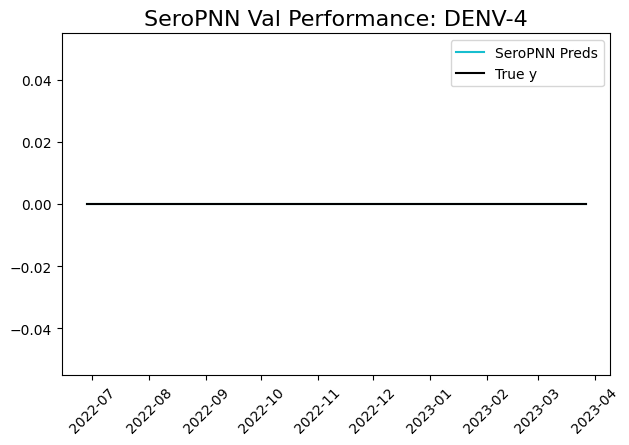

CRPS: 1484.6323604395602


In [22]:
sero_pnn_val_samples, val_y_true = eval_sero_pnn(val_sero_pnn_dataset, sero_pnn_model, N=N)
plot_sero_pnn_preds(sero_pnn_val_samples, val_sero_pnn_dataset, N, "SeroPNN Val Performance")

crps = 0
crps = sum([crps_ensemble(val_y_true[:,s], sero_pnn_val_samples[:,s,:]).mean() for s in range(N)])
print(f"CRPS: {crps}")

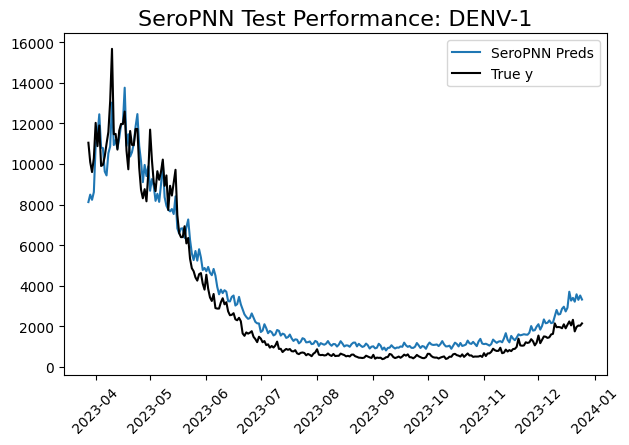

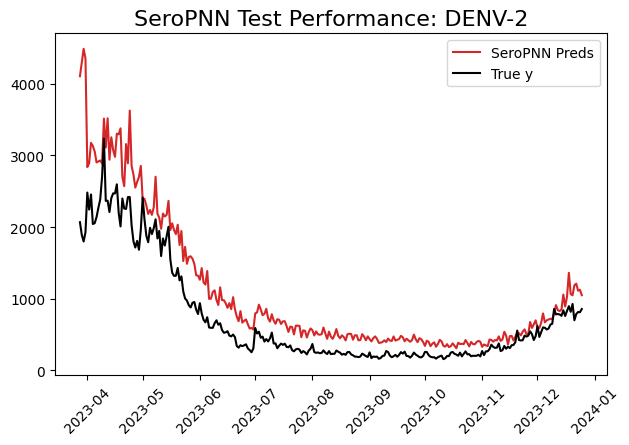

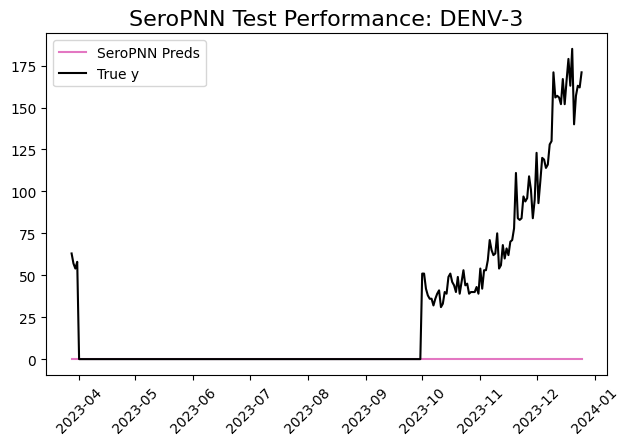

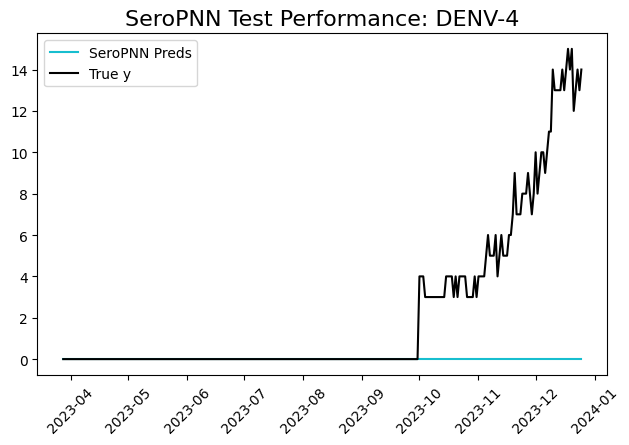

CRPS: 820.0751252747251


In [23]:
sero_pnn_test_samples, test_y_true = eval_sero_pnn(test_sero_pnn_dataset, sero_pnn_model, N=N)
plot_sero_pnn_preds(sero_pnn_test_samples, test_sero_pnn_dataset, N, "SeroPNN Test Performance")

crps = 0
crps = sum([crps_ensemble(test_y_true[:,s], sero_pnn_test_samples[:,s,:]).mean() for s in range(N)])
print(f"CRPS: {crps}")